<a href="https://colab.research.google.com/github/bullbeary-bots/Colabs/blob/main/hmm_in_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from hmmlearn.hmm import GaussianHMM
import yfinance as yf

import matplotlib.pyplot as plt

### Structure Data

In [ ]:
# Data Extraction
start_date = "2017-01-01"
end_date = "2022-06-01"
symbol = "SPY"

data = yf.download(symbol, start=start_date,
                   end=end_date, multi_level_index=False)

data.tail()


[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2022-05-24,378.134644,379.344224,371.481817,376.857826,91448800
2022-05-25,381.475433,383.472251,376.214649,376.617833,91472900
2022-05-26,389.097839,390.758651,382.512249,382.723451,82168300
2022-05-27,398.649841,398.765037,391.392239,391.593831,84768700
2022-05-31,396.413055,399.801856,393.629059,397.008251,95937000


In [ ]:
# Add returns and range
df = data.copy()
df['Returns'] = df['Close'] / df['Close'].shift(1) - 1
df['Range'] = df['High'] / df['Low'] - 1
df.dropna(inplace=True)
print('Length: ', len(df))
df.head()

Length:  1361


,Close,High,Low,Open,Volume,Returns,Range
Date,,,,,,,
2017-01-04,198.462509,198.611411,197.612880,197.621635,78744400,0.005949,0.005053
2017-01-05,198.304855,198.462525,197.499024,198.190997,78379000,-0.000794,0.004879
2017-01-06,199.014420,199.487402,197.866973,198.418797,71559900,0.003578,0.008189
2017-01-09,198.357498,198.891801,198.322454,198.751653,46939700,-0.003301,0.002871
2017-01-10,198.357498,199.224636,197.963330,198.375007,63771900,0.000000,0.006371


In [ ]:
# Add moving averages
df['MA12'] = df['Close'].rolling(12).mean()
df['MA21'] = df['Close'].rolling(21).mean()
df.dropna(inplace=True)
df.head()

,Close,High,Low,Open,Volume,Returns,Range,MA12,MA21
Date,,,,,,,,,
2017-02-02,199.504883,199.793933,198.672776,199.373489,69657600,0.000659,0.005643,199.377159,199.019396
2017-02-03,200.880035,201.063981,200.109248,200.424574,80563200,0.006893,0.004771,199.566207,199.134516
2017-02-06,200.520935,200.871305,200.179333,200.468383,57790100,-0.001788,0.003457,199.786641,199.240044
2017-02-07,200.529709,201.160362,200.337009,200.915109,57931200,0.000044,0.004110,199.947225,199.312201
2017-02-08,200.792480,200.923861,199.977882,200.529706,51566200,0.001310,0.004730,200.172771,199.428152


In [ ]:
# Structure data
X_train = df[['Returns', 'Range']].iloc[:500]
X_test = df[['Returns', 'Range']].iloc[500:]

save_df = df.iloc[500:]

print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

X_train:  (500, 2)
X_test:  (841, 2)


### Train HMM

In [ ]:
# Train HMM
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
model.fit(np.array(X_train.values))

GaussianHMM(covariance_type='full', n_components=2, n_iter=100)

In [ ]:
predictions = model.predict(X_test.values)

In [ ]:
save_df = df.iloc[500:]
df_main = save_df.copy()
df_main.drop(columns=['High', 'Low'], inplace=True)

In [ ]:
df_main['HMM'] = predictions
df_main.head()

,Close,Open,Volume,Returns,Range,MA12,MA21,HMM
Date,,,,,,,,
2019-01-30,243.469635,241.213114,92473700,0.015831,0.016159,239.491896,235.800547,0
2019-01-31,245.607910,243.405980,104012100,0.008783,0.011973,240.441977,236.667545,0
2019-02-01,245.726196,245.808083,85782500,0.000482,0.007504,241.178233,237.528912,0
2019-02-04,247.454941,245.771630,60744800,0.007035,0.009912,242.010780,238.731271,0
2019-02-05,248.492294,247.891760,79552800,0.004192,0.005738,242.779647,239.628600,0


### Run Strategy Backtest

In [ ]:
# Add MA Signals
df_main.loc[df_main['MA12'] > df_main['MA21'], 'MA_Signal'] = 1
df_main.loc[df_main['MA12'] < df_main['MA21'], 'MA_Signal'] = 0

In [ ]:
# Add HMM Signals
favourable_states = [0]
hmm_values = df_main.HMM.values
hmm_values = np.where(np.isin(hmm_values, favourable_states), 1, 0)
df_main['HMM_Signal'] = hmm_values

df_main.head()

,Close,Open,Volume,Returns,Range,MA12,MA21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets,bench_prod,bench_prod_exp,lrets_strat,strat_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2019-02-04,247.454941,245.771630,60744800,0.007035,0.009912,242.010780,238.731271,0,1.0,1,0.0,0.007011,0.007492,0.007520,0.000000,0.000000,0.000000
2019-02-05,248.492294,247.891760,79552800,0.004192,0.005738,242.779647,239.628600,0,1.0,1,0.0,0.004183,0.011675,0.011744,0.000000,0.000000,0.000000
2019-02-06,248.164703,248.210215,58347800,-0.001318,0.005222,243.255824,240.424108,0,1.0,1,0.0,-0.001319,0.010356,0.010410,-0.000000,0.000000,0.000000
2019-02-07,245.798950,246.526855,95482000,-0.009533,0.012151,243.807823,241.003408,1,1.0,0,0.0,-0.009579,0.000778,0.000778,-0.000000,0.000000,0.000000
2019-02-08,246.099274,244.534253,75788900,0.001222,0.010268,244.343149,241.545011,0,1.0,1,1.0,0.001221,0.001999,0.002001,0.009075,0.009075,0.009116


In [ ]:
# Add combined signal
df_main['Main_Signal'] = 0
df_main.loc[(df_main['HMM_Signal'] == 1) & (df_main['MA_Signal'] == 1), 'Main_Signal'] = 1
df_main['Main_Signal'] = df_main.Main_Signal.shift(1)

In [ ]:
df_main.head(10)

,Close,Open,Volume,Returns,Range,MA12,MA21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets,bench_prod,bench_prod_exp,lrets_strat,strat_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2019-02-04,247.454941,245.771630,60744800,0.007035,0.009912,242.010780,238.731271,0,1.0,1,NaN,0.007011,0.007492,0.007520,0.000000,0.000000,0.000000
2019-02-05,248.492294,247.891760,79552800,0.004192,0.005738,242.779647,239.628600,0,1.0,1,1.0,0.004183,0.011675,0.011744,0.000000,0.000000,0.000000
2019-02-06,248.164703,248.210215,58347800,-0.001318,0.005222,243.255824,240.424108,0,1.0,1,1.0,-0.001319,0.010356,0.010410,-0.000000,0.000000,0.000000
2019-02-07,245.798950,246.526855,95482000,-0.009533,0.012151,243.807823,241.003408,1,1.0,0,1.0,-0.009579,0.000778,0.000778,-0.000000,0.000000,0.000000
2019-02-08,246.099274,244.534253,75788900,0.001222,0.010268,244.343149,241.545011,0,1.0,1,0.0,0.001221,0.001999,0.002001,0.009075,0.009075,0.009116
2019-02-11,246.235794,246.763549,68021400,0.000555,0.005407,244.879232,242.053687,0,1.0,1,1.0,0.000555,0.002553,0.002556,0.000000,0.009075,0.009116
2019-02-12,249.402145,247.873529,72270200,0.012859,0.008005,245.510090,242.708808,0,1.0,1,1.0,0.012777,0.015330,0.015448,0.000000,0.009075,0.009116
2019-02-13,250.211975,250.248379,65277200,0.003247,0.004990,246.361599,243.470952,0,1.0,1,1.0,0.003242,0.018572,0.018746,-0.000000,0.009075,0.009116
2019-02-14,249.656952,249.111009,83234400,-0.002218,0.010151,247.193398,244.078849,0,1.0,1,1.0,-0.002221,0.016351,0.016486,0.000000,0.009075,0.009116


In [ ]:
# Benchmark returns
df_main['lrets'] = np.log(df_main.Close / df.Close.shift(1))
df_main['bench_prod'] = df_main.lrets.cumsum()
df_main['bench_prod_exp'] = np.exp(df_main.bench_prod) - 1

In [ ]:
# Strategy returns
df_main['lrets_strat'] = np.log(df_main.Open.shift(-1) / df.Open) * df_main.Main_Signal
df_main['strat_prod'] = df_main.lrets_strat.cumsum()
df_main['strat_prod_exp'] = np.exp(df_main.strat_prod) - 1

In [ ]:
# Review results table
df_main.dropna(inplace=True)
df_main.tail()

,Close,Open,Volume,Returns,Range,MA12,MA21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets,bench_prod,bench_prod_exp,lrets_strat,strat_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2022-05-18,376.185822,387.360243,117674500,-0.040312,0.033927,388.394651,396.796132,1,0.0,0,0.0,-0.041147,0.425865,0.530915,-0.0,0.415523,0.515164
2022-05-19,373.881805,373.075408,98510700,-0.006125,0.018160,386.241048,394.270418,1,0.0,0,0.0,-0.006144,0.419722,0.521538,0.0,0.415523,0.515164
2022-05-20,374.045013,377.520211,131432200,0.000437,0.043333,383.086642,392.056472,1,0.0,0,0.0,0.000436,0.420158,0.522202,-0.0,0.415523,0.515164
2022-05-23,381.043457,377.117029,76414900,0.018710,0.018828,381.735443,390.725275,1,0.0,0,0.0,0.018537,0.438696,0.550683,-0.0,0.415523,0.515164
2022-05-24,378.134644,376.857826,91448800,-0.007634,0.021165,380.339439,389.142645,1,0.0,0,0.0,-0.007663,0.431032,0.538845,-0.0,0.415523,0.515164


### Calculate Metrics

In [ ]:
# Sharpe ratio function
def sharpe_ratio(returns_series):
  N = 252
  n_sqrt = np.sqrt(N)
  rf = 0.01

  mean = returns_series.mean() * N
  std = returns_series.std() * n_sqrt

  return round((mean - rf) / std, 2)

In [ ]:
# Metrics
bench_rets = round(df_main.bench_prod_exp.iloc[-1]*100, 1)
strat_rets = round(df_main.strat_prod_exp.iloc[-1]*100, 1)

sharpe_bench = sharpe_ratio(df_main.lrets.values)
sharpe_strat = sharpe_ratio(df_main.lrets_strat.values)

print('Benchmark Returns: ', bench_rets, '%')
print('Strategy Returns: ', strat_rets, '%')
print('Benchmark Sharpe Ratio: ', sharpe_bench)
print('Strategy Sharpe Ratio: ', sharpe_strat)

Benchmark Returns:  53.9 %
Strategy Returns:  51.5 %
Benchmark Sharpe Ratio:  0.53
Strategy Sharpe Ratio:  1.43


### Plot Results

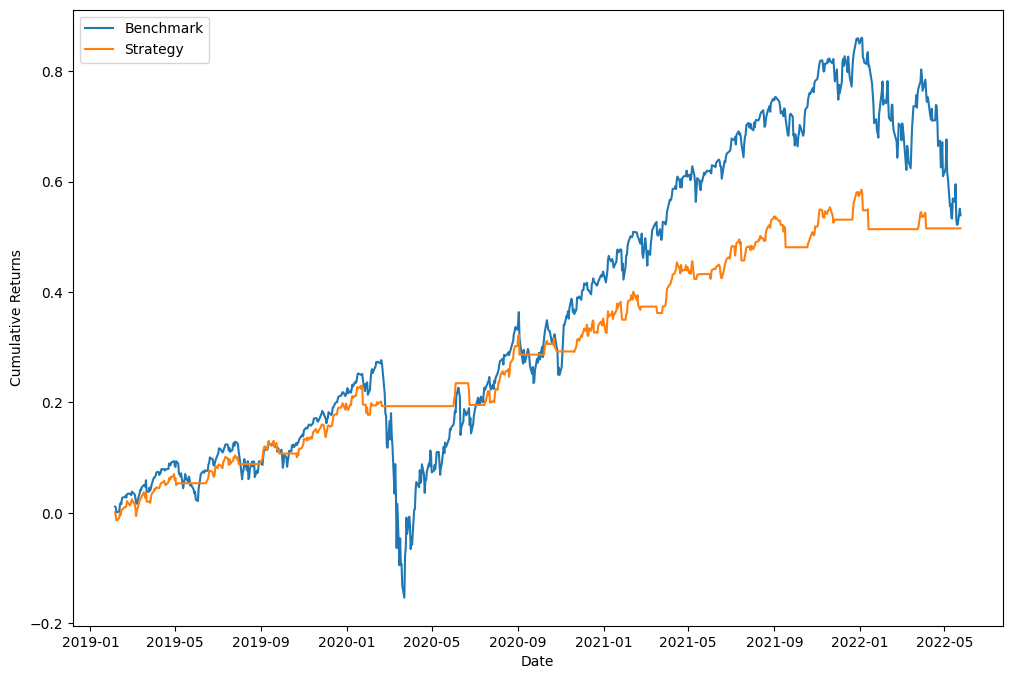

In [ ]:
# Plot equity curves
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(df_main.bench_prod_exp, label='Benchmark')
ax.plot(df_main.strat_prod_exp, label='Strategy')
ax.set_ylabel('Cumulative Returns')
ax.set_xlabel('Date')
ax.legend()
plt.show()

In [ ]:
df_main.to_csv('results.csv')